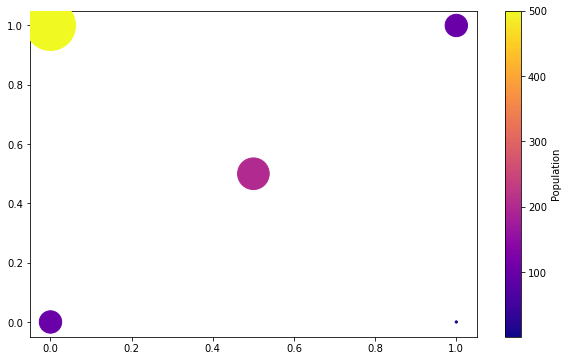

In [71]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba


n = 5

# Générer des coordonnées x et y aléatoires dans l'intervalle [0, 1]
xp = np.random.rand(n)
yp = np.random.rand(n)

# Générer des poids aléatoires dans l'intervalle [1, 500]
population = np.random.randint(1, 501, size=n)

xp = np.array([0, 1, 0, 1, 0.5])
yp = np.array([0, 0, 1, 1, 0.5])
population = np.array([100, 1, 500, 100, 200])
size = population*5


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')

In [72]:
Hs = 0.2
N = 3
Is = 50
Imin = 1
IminSol = 600
eps = 1e-1
p = 50

xt = np.linspace(0, 1, 50)
yt = np.linspace(0, 1, 50)
Xt, Yt = np.meshgrid(xt, yt)

In [73]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [74]:
@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    """
    Dans cette version, on va essayer d'imposer une surface au sol qui a une intensité minimale à l'aide d'une contrainte, 
    on ne cherche donc pas à maximiser quoique ce soit
    """
    
    
    return 0
        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


@numba.jit(nopython = True, parallel = True)
def contrainte2(x) : 
    somme = 0
    for j in numba.prange(p) : 
        for k in numba.prange(p) : 
            sum_point = 0
            for i in numba.prange(N) : 
                di_sq = pyth(j/p, x[2*i], k/p, x[2*i+1]) + Hs**2

                sum_point += Is/(di_sq)
            if sum_point >= IminSol : 
                somme+=1
  
    return somme/(p**2)
    

In [75]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
myc2 = NonlinearConstraint(contrainte2, 0.7, 1)
contraintes = [myc1, myc2]
x0 = [1] * 2*N
t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte2(resultat.x))

temps :  2.1814208030700684
     fun: 0.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 54
  status: 1
 success: True
       x: array([0.29118018, 0.94492547, 0.89550013, 0.59883274, 0.23430185,
       0.42472656])
Résultat de l'optimisation: 0.0
Valeurs optimales des variables: [0.29118018 0.94492547 0.89550013 0.59883274 0.23430185 0.42472656]
Valeur de la contrainte 1 :  0.9999953524514001
Valeur de la contrainte 2 :  0.7028


/home/ines/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../tmp/ipykernel_5799/642254829.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


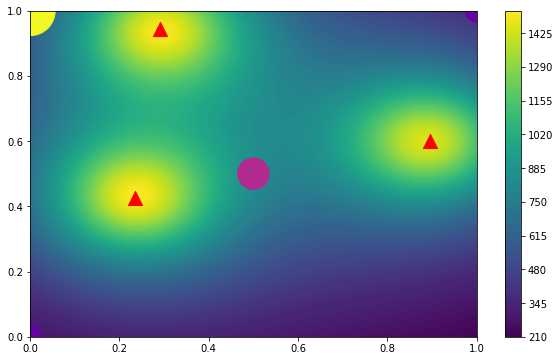

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, ax = ax)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)

In [77]:
def contrainte1(vars,j) :
    
    sumj = 0
    for i in range(N) : 
        dij_sq = pyth(xp[j], vars[2*i], yp[j], vars[2*i+1]) + Hs**2
        sumj += Is/(dij_sq)
        
    return sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]


def contrainte2(vars) :
    somme = 0
    for j in range(p) : 
        for k in range(p) : 
            sum_point = 0
            for i in range(N) : 
                di_sq = pyth(j/p, vars[2*i], k/p, vars[2*i+1]) + Hs**2

                sum_point += Is/(di_sq)
            if sum_point >= IminSol : 
                somme+=1
  
    return somme/(p**2)

def objectif(vars) :
    return 0

In [80]:
from gurobipy import Model, GRB
import numpy as np
import numba

# Define problem parameters (ensure these values are appropriate for your problem)
# N = 10  # Number of points to locate
# population = [1, 2, 3, 4, 5]  # Population sizes (assuming these sizes are valid)
# p = 3  # Number of potential locations
# Is = 1  # Parameter for repulsion
# Imin = 0.1  # Minimum influence
# M = 100  # Steepness parameter for sigmoid
# Hs = 0.01  # Smoothing parameter

# Create Gurobi model
model = Model("MyOptimizationProblem")

# Define decision variables (assuming `N` is valid and even)
vars = model.addVars(N, 2, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="Location")
print(vars)

# Define objective function (replace with your actual objective function)
# In this example, objective is set to 0 for demonstration purposes
model.setObjective(objectif(vars), GRB.MINIMIZE)

# Ensure `xp` and `yp` lists are defined and have appropriate lengths (N elements)
try:
    if len(xp) <= 0 or len(yp) <= 0:
        raise ValueError("xp and yp lists must have at least one element")
except NameError:
    print("xp and yp lists are not defined. Please provide appropriate data.")
except ValueError as e:
    print(f"Invalid list lengths: {e}")
    exit(1)


@numba.jit(nopython=True)
def pyth(x1, y1, x2, y2):
    # Replace with your actual implementation of the Euclidean distance function
    return (x2 - x1) ** 2 + (y2 - y1) ** 2

@numba.jit(nopython=True)
def sigmoid(x, center=0, M=100):
    return 1 / (1 + np.exp(-M * (x - center)))  # Assuming np.exp is available in numba

# Define constraints
def contrainte1_gurobi(vars, j):
    somme = 0
    for i in range(N):
        dij_sq = pyth(xp[j], vars[(i,0)], yp[j], vars[(i,1)]) + Hs**2
        somme += Is / dij_sq
    return sigmoid(somme / population[j], center=Imin, M=M) * population[j]

# Add constraint 1 for each individual in the population
for j in range(len(population)):
    try:
        model.addConstr(sum(contrainte1_gurobi(vars, j) for i in range(N)) / sum(population) == 0, f"Constraint1_{j}")
    except IndexError as e:
        print(f"Error adding constraint 1 for individual {j}: {e}")

def contrainte2_gurobi(vars, j, k):
    sum_point = 0
    for i in range(N):
        di_sq = pyth(j/p, vars[(i,0)], k/p, vars[(i,1)]) + Hs**2
        sum_point += Is / di_sq
    return sum_point >= IminSol

# Add constraint 2 for all pairs of potential locations
for j in range(p):
    for k in range(p):
        if j != k:
            model.addConstr(contrainte2_gurobi(vars, j, k), f"Constraint2_{j}_{k}")

# Solve the model
# try:
#     model.optimize()
# except GurobiError as e:
#     print(f"Optimization failed: {e}")
# else:
#     # Print results (adjust based on your solution extraction needs)
#     if model.status == GRB.OPTIMAL:
#         for v in model.getVars():
#             print(f"{v.varName} = {v.x}")
#         print(f"Objective value: {model.objVal}")
#     else:
#         print("Optimization status:", model.status)  # Check for other potential statuses


{(0, 0): <gurobi.Var *Awaiting Model Update*>, (0, 1): <gurobi.Var *Awaiting Model Update*>, (1, 0): <gurobi.Var *Awaiting Model Update*>, (1, 1): <gurobi.Var *Awaiting Model Update*>, (2, 0): <gurobi.Var *Awaiting Model Update*>, (2, 1): <gurobi.Var *Awaiting Model Update*>}


GurobiError: Variable has not yet been added to the model

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp

m = gp.Model("mip1")
m.setParam('OutputFlag', 0)
m.setParam('NonConvex', 2)
vars = m.addVars(N, 2, lb=0, ub=1, vtype=GRB.CONTINUOUS)

for j in range(len(population)) : 
    m.addConstr(contrainte1(vars,j) >= 0.8)
m.addConstr(contrainte2(vars) >= 0.7)
m.setObjective(objectif(vars), GRB.MINIMIZE)

m.optimize()
print(m.getVars())
m.getVal("x")

TypeError: 'int' object is not subscriptable